## Import pakietów

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from scipy.linalg import eigh
from numpy.linalg import norm

In [8]:
def generate_AR1_covariance(p, rho):
    """Generuje macierz kowariancji AR(1) o wymiarze p i współczynniku rho"""
    return np.array([[rho ** abs(i - j) for j in range(p)] for i in range(p)])

def generate_constant_covariance(p):
    """Generuje jednostkową macierz kowariancji"""
    return np.eye(p)

def generate_MA1_covariance(p, rho):
    """Generuje macierz kowariancji MA(1) o wymiarze p i współczynniku rho"""
    cov_matrix = np.eye(p) 
    for i in range(p - 1):
        cov_matrix[i, i + 1] = rho
        cov_matrix[i + 1, i] = rho
    return cov_matrix

def sample_covariance(X):
    """Zwraca próbkową macierz kowariancji"""
    n = X.shape[0]
    mean = np.mean(X, axis=0)
    centered_X = X - mean
    cov_matrix = np.dot(centered_X.T, centered_X) / n
    return cov_matrix

def thresholding_estimator(S, t):
    """Zwraca estymator progowy macierzy kowariancji"""
    return np.where(np.abs(S) > t, S, 0)

def banding_estimator(S, k):
    """Zwraca estymator pasmowy macierzy kowariancji"""
    p = S.shape[0]
    banded_S = np.zeros_like(S)
    for i in range(p):
        for j in range(max(0, i - k), min(p, i + k + 1)):
            banded_S[i, j] = S[i, j]
    return banded_S

def thresholding_cv(X,p,n,s_vals,N):
    """Wybór progu za pomocą walidacji krzyżowej"""
    n1=int(n*(1-1/np.log(n)))
    n2=n-n1
    
    R_s_values=[]
    for s in s_vals:
        total=0
        for _ in range(N):
            indices=np.random.permutation(n)
            X1,X2=X[indices[:n1]], X[indices[n1:]]
            S1=sample_covariance(X1)
            S2=sample_covariance(X2)
            T=thresholding_estimator(S1,s)
            total+=np.linalg.norm(T-S2, 'fro') ** 2
        R_s=total/N
        R_s_values.append((s,R_s))
    optimal_s, min_loss=min(R_s_values, key=lambda x: x[1])
    print(f"Optimal CV threshold for {p} is {optimal_s}. Loss={min_loss}")
    return optimal_s, R_s_values

def thresholding_oracle(X,p,s_vals, matrix):
    """Wybór progu z użyciem prawdziwej macierzy kowariancji"""
    R_s_values=[]
    for s in s_vals:
        T=thresholding_estimator(sample_covariance(X),s)
        R_s=np.linalg.norm(T-matrix,'fro')**2
        R_s_values.append((s,R_s))
    optimal_s, min_loss=min(R_s_values, key=lambda x: x[1])
    print(f"Optimal oracle threshold for {p} is {optimal_s}. Loss={min_loss}")
    return optimal_s, R_s_values

def banding_cv(X,p,n,k_vals,N):
    """Wybór progu za pomocą walidacji krzyżowej"""
    #n1=int(n/3)
    n1=int(n*(1-1/np.log(n)))
    n2=n-n1
    
    R_s_values=[]
    for k in k_vals:
        total=0
        for _ in range(N):
            indices=np.random.permutation(n)
            X1,X2=X[indices[:n1]], X[indices[n1:]]
            S1=sample_covariance(X1)
            S2=sample_covariance(X2)
            B=banding_estimator(S1,k)
            total+=np.linalg.norm(B-S2, 1)
        R_s=total/N
        R_s_values.append((k,R_s))
    optimal_k, min_loss=min(R_s_values, key=lambda x: x[1])
    print(f"Optimal CV band width for {p} is {optimal_k}. Loss={min_loss}")
    return optimal_k, R_s_values

def banding_oracle(X,p,k_vals,matrix):
    """Wybór progu z użyciem prawdziwej macierzy kowariancji"""
    R_s_values=[]
    for k in k_vals:
        B=banding_estimator(sample_covariance(X),k)
        R_s=np.linalg.norm(B-matrix,1)
        R_s_values.append((k,R_s))
    optimal_k, min_loss=min(R_s_values, key=lambda x: x[1])
    print(f"Optimal oracle band width for {p} is {optimal_k}.Loss={min_loss}")
    return optimal_k, R_s_values


# Wybór progu i szerokości pasma dla AR(1)

Optimal CV threshold for 30 is 0.24000000000000002. Loss=46.77415740163871
Optimal oracle threshold for 30 is 0.22. Loss=9.59438027714123
Optimal CV band width for 30 is 6. Loss=7.726974757906983
Optimal oracle band width for 30 is 6.Loss=2.3148592104762233


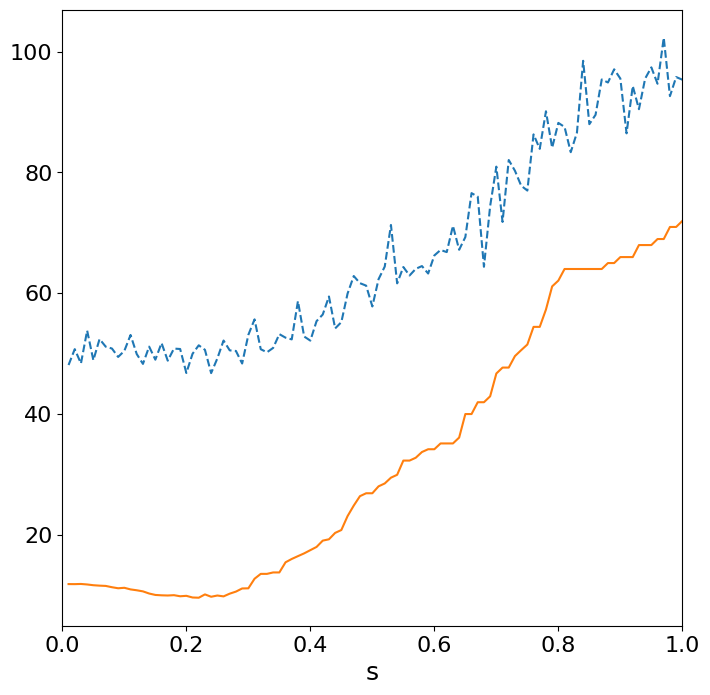

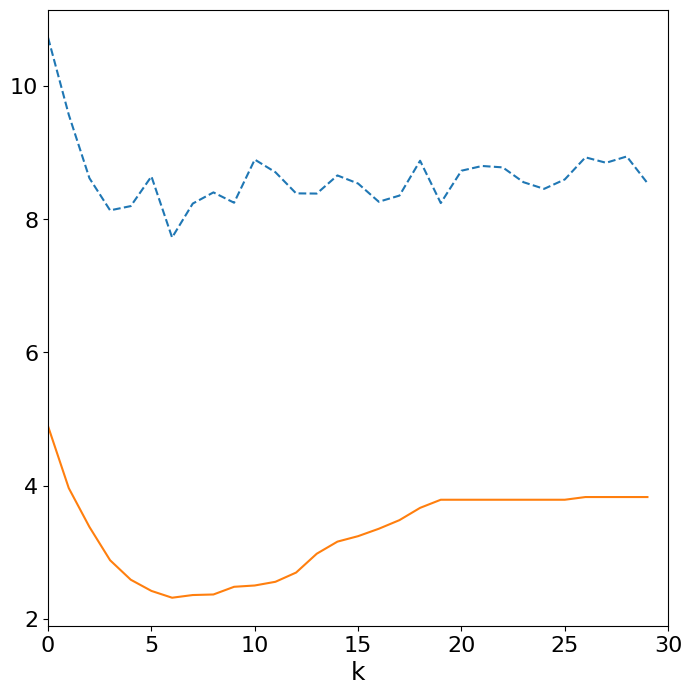

Optimal CV threshold for 100 is 0.31. Loss=513.6406110683612
Optimal oracle threshold for 100 is 0.26. Loss=36.08342320095415
Optimal CV band width for 100 is 7. Loss=26.395820809240902
Optimal oracle band width for 100 is 6.Loss=2.7027387665853135


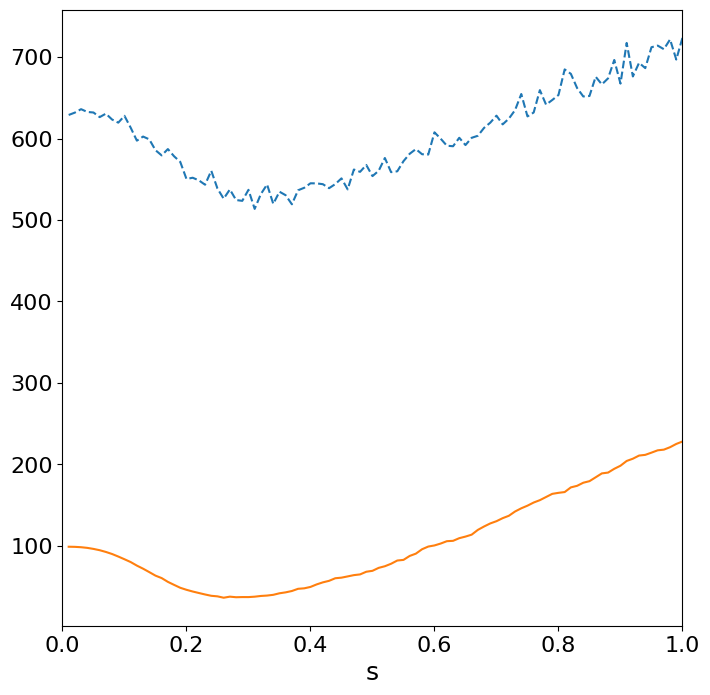

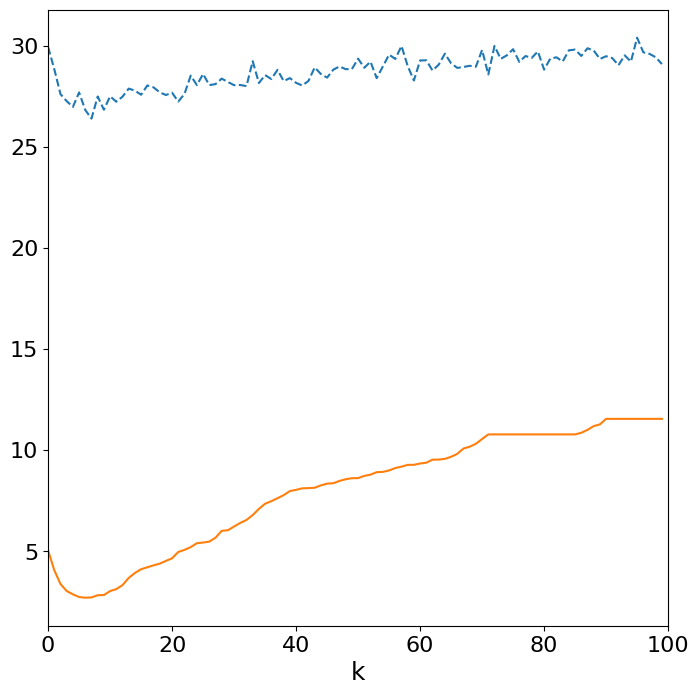

Optimal CV threshold for 200 is 0.31. Loss=1845.7044252924948
Optimal oracle threshold for 200 is 0.3. Loss=84.6134549849751
Optimal CV band width for 200 is 7. Loss=50.721433952484546
Optimal oracle band width for 200 is 5.Loss=4.2240148561738815


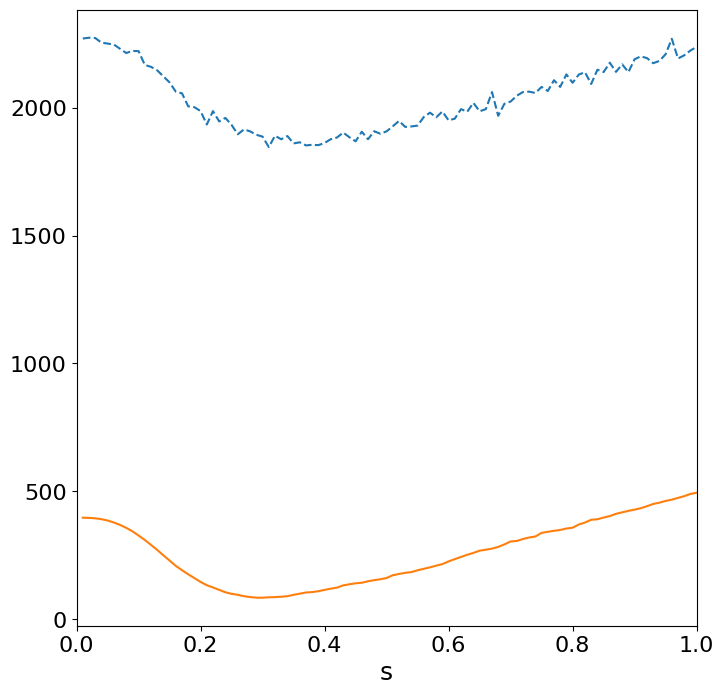

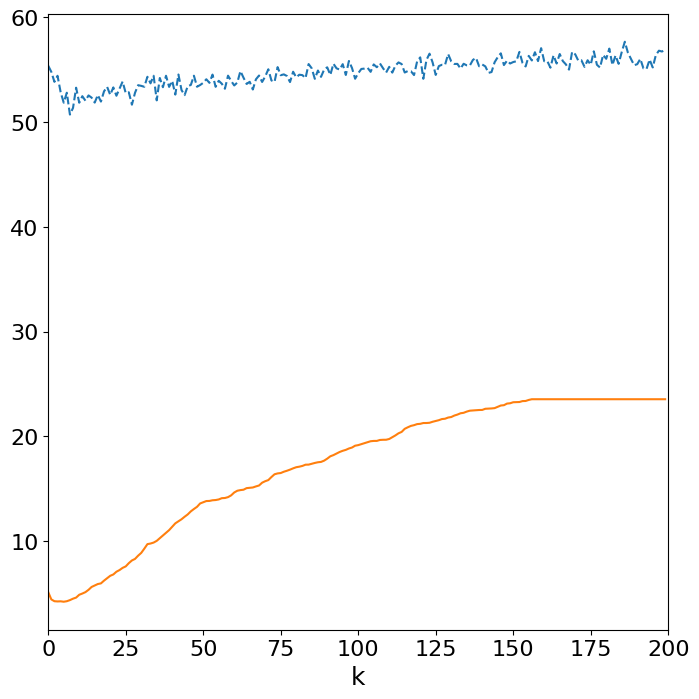

In [9]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.7
n = 100
N = 50
s_vals = np.linspace(0.01, 1, 100)

# Ścieżka do pulpitu
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

for p in p_values:
    k_vals = range(0, p)
    true_cov = generate_AR1_covariance(p, rho)
    X = np.random.multivariate_normal(np.zeros(p), true_cov, n)
    
    t_cv = thresholding_cv(X, p, n, s_vals, N)[1]
    t_o = thresholding_oracle(X, p, s_vals, true_cov)[1]
    b_cv = banding_cv(X, p, n, k_vals, N)[1]
    b_o = banding_oracle(X, p, k_vals, true_cov)[1]
    
    s_vals_cv, R_s_vals_cv = zip(*t_cv)
    s_vals_o, R_s_vals_o = zip(*t_o)
    s_vals_b_cv, R_s_vals_b_cv = zip(*b_cv)
    s_vals_b_o, R_s_vals_b_o = zip(*b_o)

    plt.figure(figsize=(8, 8)) 
    plt.plot(s_vals_cv, R_s_vals_cv, label=r'$\hat{R}(s)$', linestyle='--')
    plt.plot(s_vals_o, R_s_vals_o, label=r'$R_1(s)$', linestyle='-')
    plt.xlabel("s", fontsize=18)
    plt.xlim(0, 1)
    
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # frobenius_filename = os.path.join(desktop_path, f'frobenius_p_{p}.svg')
    # plt.savefig(frobenius_filename, format='svg')
    
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 8))  
    plt.plot(s_vals_b_cv, R_s_vals_b_cv, label=r'$\hat{R}(k)$', linestyle='--')
    plt.plot(s_vals_b_o, R_s_vals_b_o, label=r'$R_1(k)$', linestyle='-')
    plt.xlabel("k", fontsize=18) 
    plt.xlim(0, p)
    
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # first_norm_filename = os.path.join(desktop_path, f'first_norm_p_{p}.svg')
    # plt.savefig(first_norm_filename, format='svg')
    
    plt.show()
    plt.close()


## Wybór progu i szerokości pama dla MA(1)

Optimal CV threshold for 30 is 0.33. Loss=40.458561380949526
Optimal oracle threshold for 30 is 0.32. Loss=2.141670132212585
Optimal CV band width for 30 is 2. Loss=7.189786648667484
Optimal oracle band width for 30 is 1.Loss=0.7491092782632688


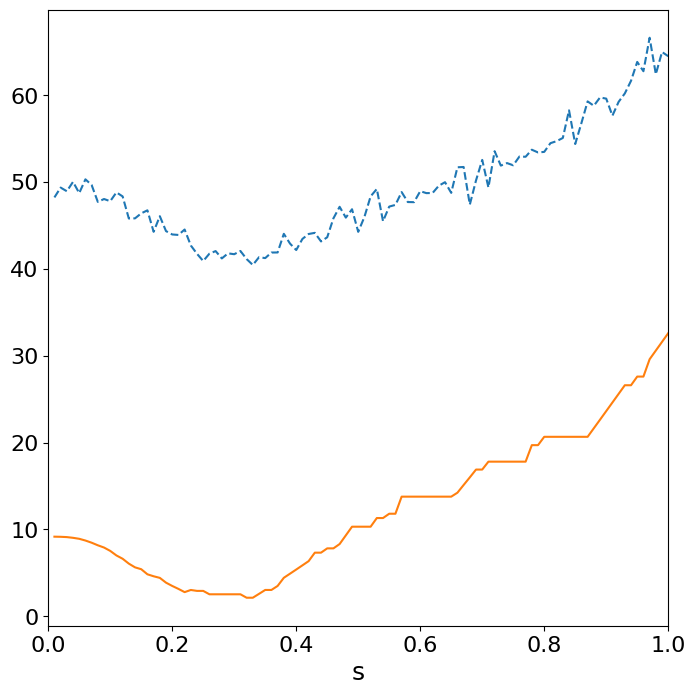

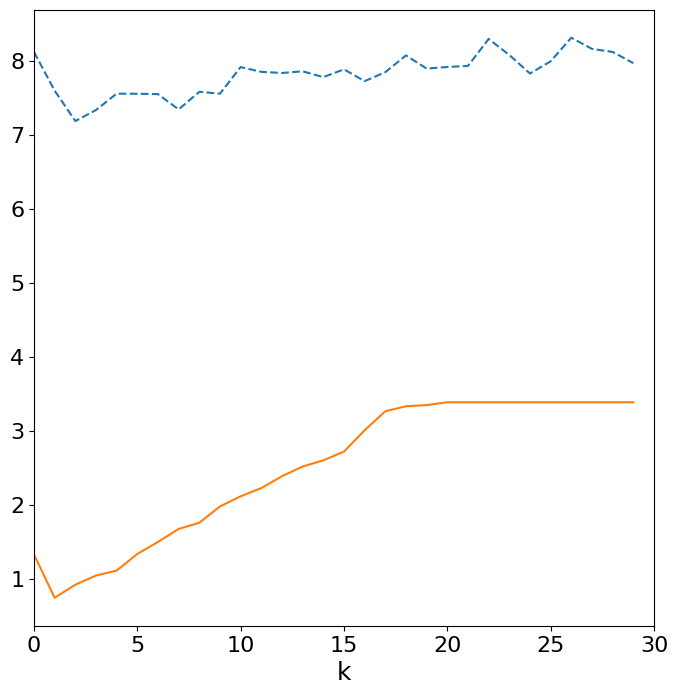

Optimal CV threshold for 100 is 0.37. Loss=478.22044964620005
Optimal oracle threshold for 100 is 0.32. Loss=7.903417117859557
Optimal CV band width for 100 is 2. Loss=25.97294983025875
Optimal oracle band width for 100 is 1.Loss=1.1471914412408069


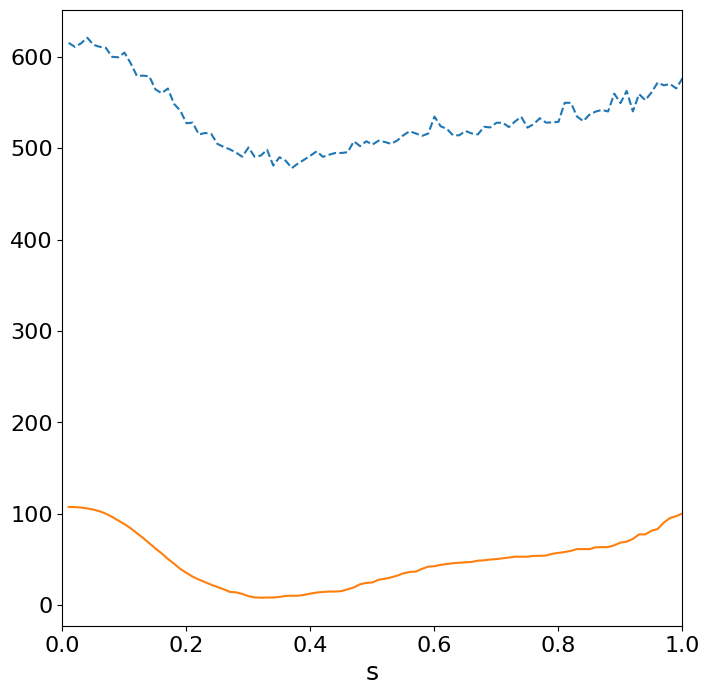

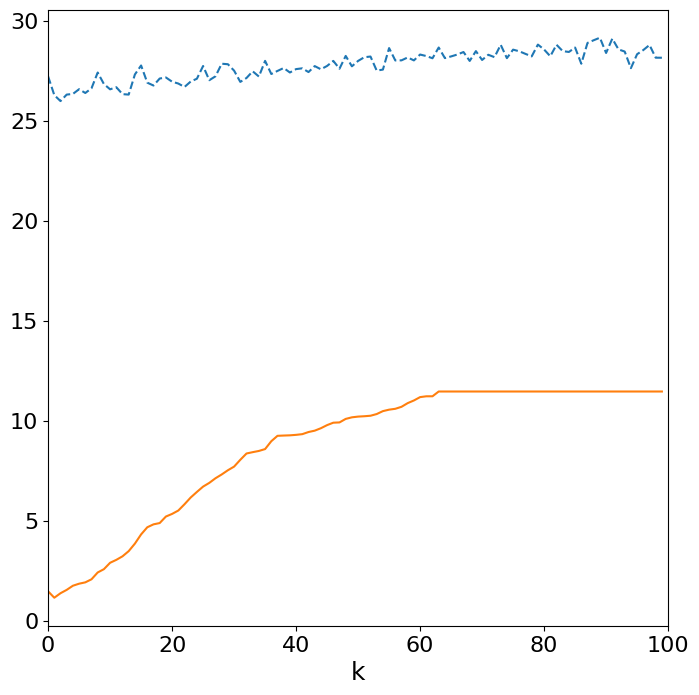

Optimal CV threshold for 200 is 0.38. Loss=1698.2555944557491
Optimal oracle threshold for 200 is 0.33. Loss=19.713566623847413
Optimal CV band width for 200 is 4. Loss=48.790171619569406
Optimal oracle band width for 200 is 1.Loss=0.8078972734156046


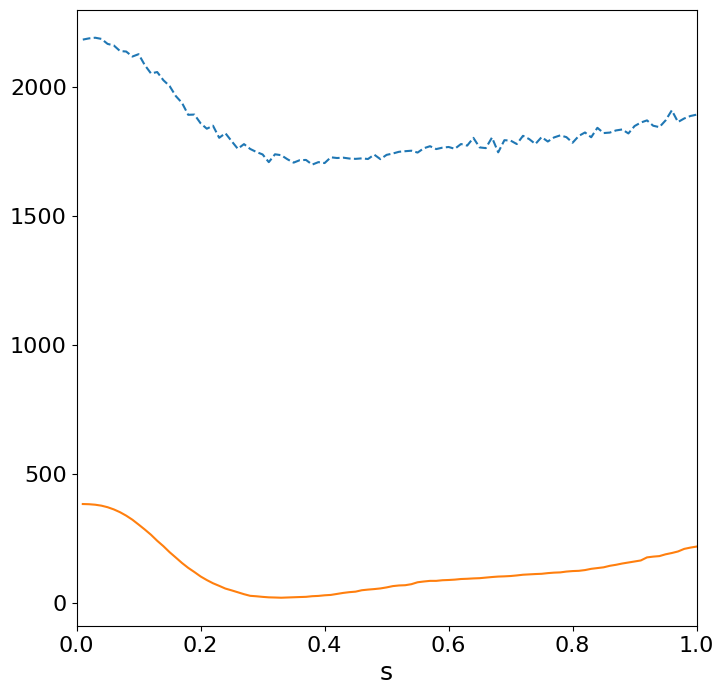

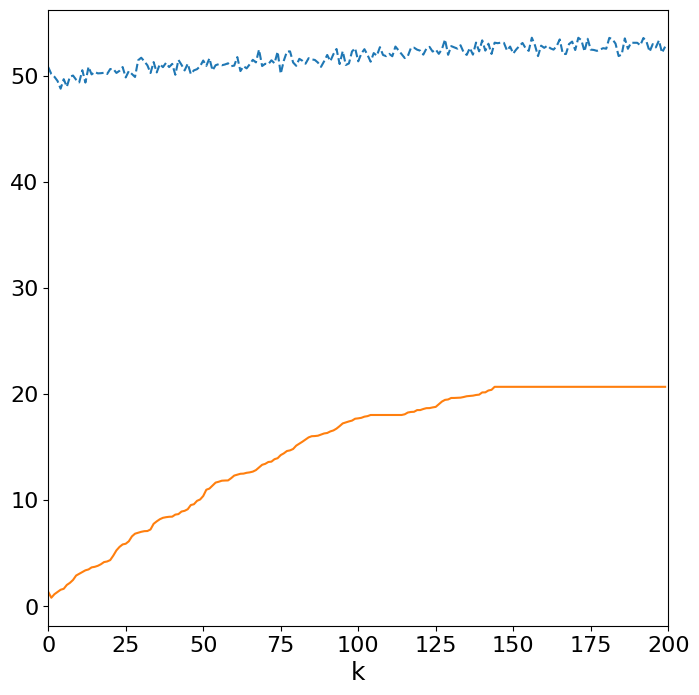

In [ ]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.5
n = 100
N = 50
s_vals = np.linspace(0.01, 1, 100)

# Ścieżka do pulpitu
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

for p in p_values:
    k_vals = range(0, p)
    true_cov = generate_MA1_covariance(p, rho)
    X = np.random.multivariate_normal(np.zeros(p), true_cov, n)
    
    t_cv = thresholding_cv(X, p, n, s_vals, N)[1]
    t_o = thresholding_oracle(X, p, s_vals, true_cov)[1]
    b_cv = banding_cv(X, p, n, k_vals, N)[1]
    b_o = banding_oracle(X, p, k_vals, true_cov)[1]
    
    s_vals_cv, R_s_vals_cv = zip(*t_cv)
    s_vals_o, R_s_vals_o = zip(*t_o)
    s_vals_b_cv, R_s_vals_b_cv = zip(*b_cv)
    s_vals_b_o, R_s_vals_b_o = zip(*b_o)

    plt.figure(figsize=(8, 8)) 
    plt.plot(s_vals_cv, R_s_vals_cv, label=r'$\hat{R}(s)$', linestyle='--')
    plt.plot(s_vals_o, R_s_vals_o, label=r'$R_1(s)$', linestyle='-')
    plt.xlabel("s", fontsize=18)  
    plt.xlim(0, 1)
    
    plt.tick_params(axis='both', which='major', labelsize=16)

    # frobenius_filename = os.path.join(desktop_path, f'frobenius_p_{p}_ma.svg')
    # plt.savefig(frobenius_filename, format='svg')
    
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 8))
    plt.plot(s_vals_b_cv, R_s_vals_b_cv, label=r'$\hat{R}(k)$', linestyle='--')
    plt.plot(s_vals_b_o, R_s_vals_b_o, label=r'$R_1(k)$', linestyle='-')
    plt.xlabel("k", fontsize=18)
    plt.xlim(0, p)

    plt.tick_params(axis='both', which='major', labelsize=16)

    # first_norm_filename = os.path.join(desktop_path, f'first_norm_p_{p}_ma.svg')
    # plt.savefig(first_norm_filename, format='svg')
    
    plt.show()
    plt.close()
